# Housing Market
## Author: Daniel Antantis
### Date: April 19, 2023

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
%matplotlib inline

In [64]:
houses = pd.read_csv("train.csv")

In [65]:
houses.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


Text(0.5, 1.0, 'Distribution of House Sale Prices')

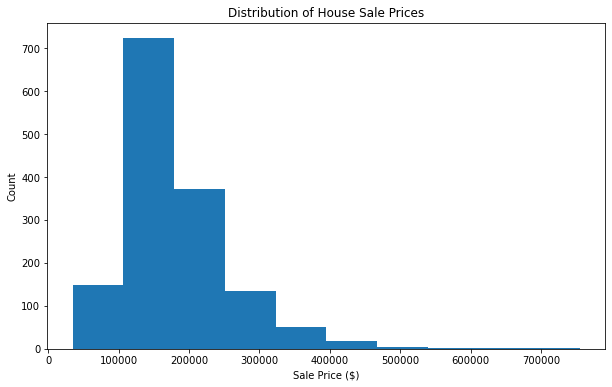

In [66]:
fig = plt.figure(figsize=(10, 6))
plt.hist(houses["SalePrice"])
plt.xlabel('Sale Price ($)')
plt.ylabel('Count')
plt.title('Distribution of House Sale Prices')

Response variable isn't normally distributed and appears to be right skewed, so therefore a log-transformation may help normalize the distribution and improve prediction results.

Text(0.5, 1.0, 'Distribution of House Sale Prices After Log-Transformation')

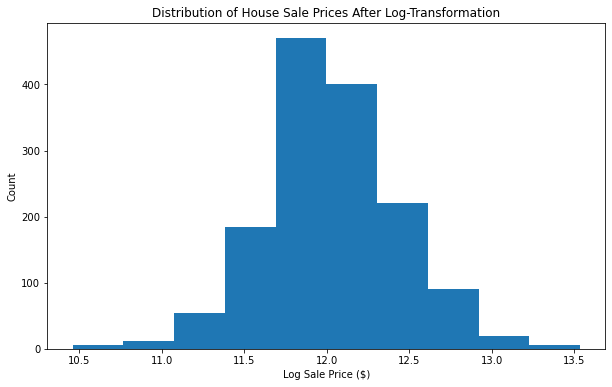

In [67]:
houses['SalePrice_log'] = np.log(houses['SalePrice'])
fig = plt.figure(figsize=(10, 6))
plt.hist(houses["SalePrice_log"])
plt.xlabel('Log Sale Price ($)')
plt.ylabel('Count')
plt.title('Distribution of House Sale Prices After Log-Transformation')

After the transformation the sale price distribution is much more normally distributed.

In [68]:
# Let's investigate the houses with unusually large sale prices
houses[houses['SalePrice'] > 500000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log
178,179,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2009,New,Partial,501837,13.126031
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2009,WD,Normal,555000,13.226723
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,1,2007,WD,Normal,755000,13.534473
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,...,NaN,NaN,NaN,0,6,2010,WD,Normal,538000,13.195614
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,1,2009,New,Partial,582933,13.275828
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,3,2010,New,Partial,611657,13.323927
1046,1047,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2006,New,Partial,556581,13.229568
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2006,WD,Normal,625000,13.345507
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000,13.521139


In [72]:
houses = houses[houses['SalePrice'] < 500000]

# Missing Data

In [73]:
missing_data = houses.isnull().sum()
missing_data.iloc[missing_data.to_numpy().nonzero()]

LotFrontage      259
Alley           1360
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1445
Fence           1171
MiscFeature     1397
dtype: int64

Lots of missing data to work with this dataset, most noteably the 'Alley', 'PoolQC', 'Fence', 'FireplaceQu', and 'MiscFeature'. This is expected since the majority of houses do not have most of these features and the same is true for the other variables relating to basements and garages.

# Collinearity

In [74]:
houses_num = houses.select_dtypes(include = ['float64', 'int64'])
corr_matrix = houses_num.corr()
corr_matrix['SalePrice'].sort_values(ascending = False)

SalePrice        1.000000
SalePrice_log    0.961648
OverallQual      0.802424
GrLivArea        0.686872
GarageCars       0.654418
GarageArea       0.633607
TotalBsmtSF      0.596771
1stFlrSF         0.589676
FullBath         0.553014
YearBuilt        0.543898
YearRemodAdd     0.531708
TotRmsAbvGrd     0.510964
GarageYrBlt      0.506321
Fireplaces       0.469693
MasVnrArea       0.442144
BsmtFinSF1       0.357076
LotFrontage      0.339320
OpenPorchSF      0.332686
WoodDeckSF       0.331999
2ndFlrSF         0.292447
HalfBath         0.284007
LotArea          0.252156
BsmtFullBath     0.236628
BsmtUnfSF        0.223991
BedroomAbvGr     0.166543
ScreenPorch      0.097277
MoSold           0.074689
3SsnPorch        0.053722
PoolArea         0.032260
BsmtFinSF2      -0.014028
MiscVal         -0.020247
LowQualFinSF    -0.023940
Id              -0.032967
BsmtHalfBath    -0.033044
YrSold          -0.036607
OverallCond     -0.072195
MSSubClass      -0.085954
EnclosedPorch   -0.129293
KitchenAbvGr

Overall Quality Rating, Living Area (sqft), and Garage Space seem to have the highest correlation with the response variable Sale Price.

In [75]:
high_corr = corr_matrix[corr_matrix < 1].unstack().sort_values(ascending= False).drop_duplicates()
high_corr[abs(high_corr) > 0.6]

SalePrice_log  SalePrice        0.961648
GarageArea     GarageCars       0.881573
GrLivArea      TotRmsAbvGrd     0.825282
YearBuilt      GarageYrBlt      0.824447
1stFlrSF       TotalBsmtSF      0.811904
OverallQual    SalePrice_log    0.810603
               SalePrice        0.802424
SalePrice      GrLivArea        0.686872
TotRmsAbvGrd   BedroomAbvGr     0.685785
GrLivArea      SalePrice_log    0.683607
               2ndFlrSF         0.678863
SalePrice_log  GarageCars       0.675514
SalePrice      GarageCars       0.654418
BsmtFinSF1     BsmtFullBath     0.652108
GarageArea     SalePrice_log    0.643988
GarageYrBlt    YearRemodAdd     0.640051
SalePrice      GarageArea       0.633607
FullBath       GrLivArea        0.617605
2ndFlrSF       TotRmsAbvGrd     0.614840
HalfBath       2ndFlrSF         0.609237
dtype: float64

Most of the variables that are exhibiting collinearity are complementory variables and therefore one can be removed since one of them can sufficiently explain the other.

In [76]:
houses = houses.drop(['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd'], axis = 1)
houses = houses.rename(columns = {'1stFlrSF': 'FirstFlrSF', '2ndFlrSF': 'SecondFlrSF'})
houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429216


# Variable Exploration

Text(0.5, 1.0, 'House Sale Prices and Lot Area')

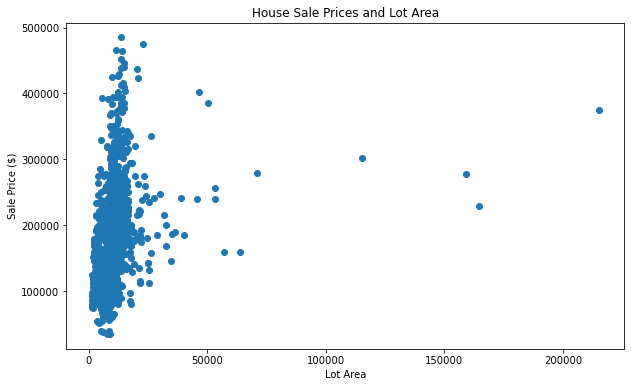

In [77]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(houses['LotArea'], houses['SalePrice'])
plt.xlabel('Lot Area')
plt.ylabel('Sale Price ($)')
plt.title('House Sale Prices and Lot Area')

A few outliers are making this relaationship very skewed so a closer look may be necessary.

In [78]:
houses[houses['LotArea'] > 100000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,NaN,NaN,Shed,500,6,2007,WD,Normal,277000,12.531773
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,NaN,NaN,NaN,0,6,2009,WD,Normal,375000,12.834681
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,NaN,NaN,Shed,700,8,2008,WD,Normal,228950,12.341259
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,NaN,NaN,NaN,0,6,2007,WD,Normal,302000,12.618182


These specific sales seem to be clearly outliers for this dataset so removing them will be benficial.

Text(0.5, 1.0, 'House Sale Prices and Lot Area (no outliers)')

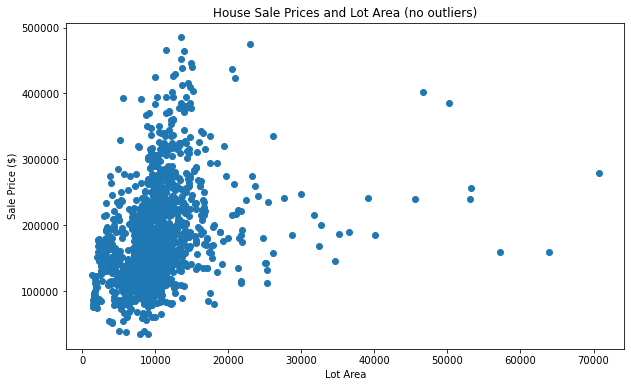

In [79]:
houses = houses[houses['LotArea'] < 100000]
fig = plt.figure(figsize=(10, 6))
plt.scatter(houses['LotArea'], houses['SalePrice'])
plt.xlabel('Lot Area')
plt.ylabel('Sale Price ($)')
plt.title('House Sale Prices and Lot Area (no outliers)')

Text(0.5, 1.0, 'House Sale Prices and Year Built')

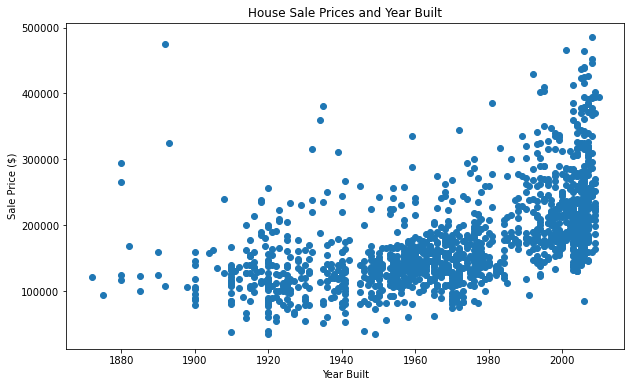

In [80]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(houses['YearBuilt'], houses['SalePrice'])
plt.xlabel('Year Built')
plt.ylabel('Sale Price ($)')
plt.title('House Sale Prices and Year Built')

Obvious left skewed relationship as we would expect houses that are newer to sell for higher prices than older ones.

Text(0.5, 1.0, 'House Sale Prices and Ground Living Area')

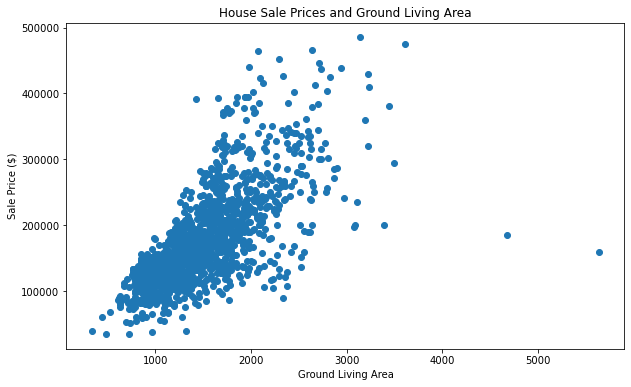

In [81]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(houses['GrLivArea'], houses['SalePrice'])
plt.xlabel('Ground Living Area')
plt.ylabel('Sale Price ($)')
plt.title('House Sale Prices and Ground Living Area')

OK now we're getting somewhere! Except for a few outliers there is a moderately strong linear relationship between ground living area space and house sale price.

Text(0.5, 1.0, 'House Sale Prices and Garage Area')

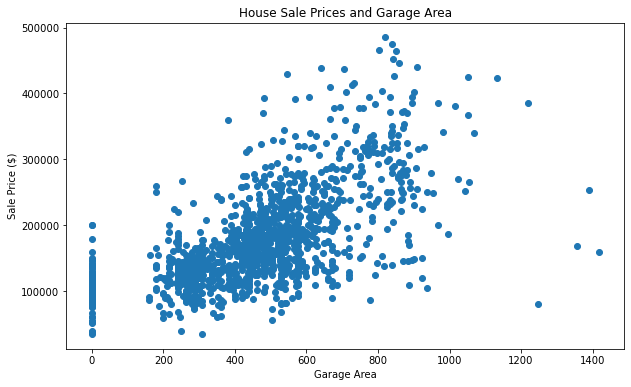

In [82]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(houses['GarageArea'], houses['SalePrice'])
plt.xlabel('Garage Area')
plt.ylabel('Sale Price ($)')
plt.title('House Sale Prices and Garage Area')

This relationship is a little bit more complex since there are houses without any garage area but it is clear that houses with more garage area tend to have higher sale prices

Text(0.5, 1.0, 'House Sale Prices and Pool Area')

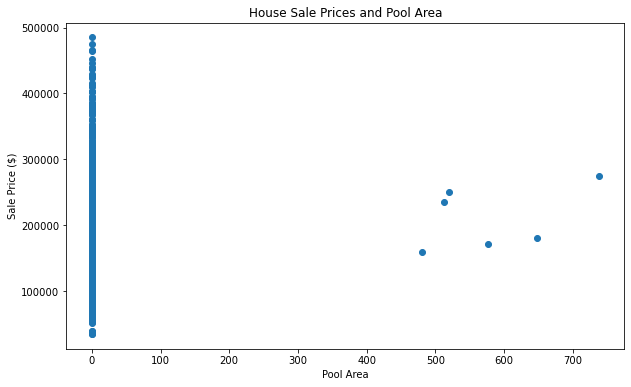

In [83]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(houses['PoolArea'], houses['SalePrice'])
plt.xlabel('Pool Area')
plt.ylabel('Sale Price ($)')
plt.title('House Sale Prices and Pool Area')

Doesn't appear to be a lot of houses in the dataset that have pools so it is probably safe to ignore this predictor.

# Categorical Variable Exploration

Text(0.5, 1.0, 'House Sale Prices by MS Sub Class')

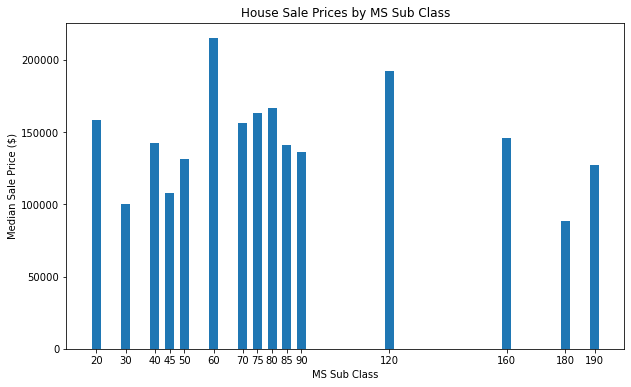

In [84]:
subclass = houses.groupby('MSSubClass').aggregate({'SalePrice': 'median'}).reset_index().sort_values('SalePrice')
fig = plt.figure(figsize=(10, 6))
plt.bar(subclass['MSSubClass'], subclass['SalePrice'], align = 'center', width = 3)
plt.xticks(subclass['MSSubClass'], subclass['MSSubClass'], rotation = 0, fontsize = 10)
plt.xlabel('MS Sub Class')
plt.ylabel('Median Sale Price ($)')
plt.title('House Sale Prices by MS Sub Class')

Text(0.5, 1.0, 'House Sale Prices by Neighborhood')

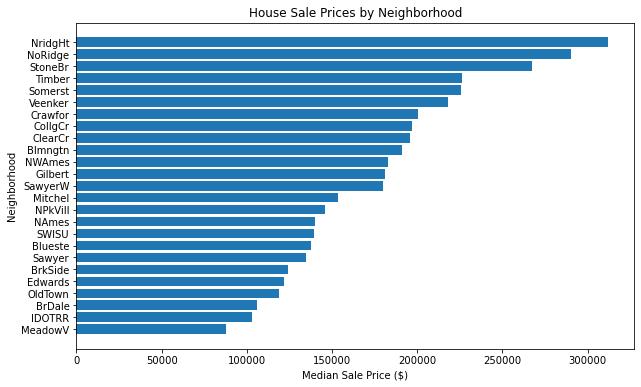

In [85]:
neighborhood = houses.groupby('Neighborhood').aggregate({'SalePrice': 'median'}).reset_index().sort_values('SalePrice')
fig = plt.figure(figsize=(10, 6))
plt.barh(neighborhood['Neighborhood'], neighborhood['SalePrice'], align = 'center')
plt.ylabel('Neighborhood')
plt.xlabel('Median Sale Price ($)')
plt.title('House Sale Prices by Neighborhood')

Text(0.5, 1.0, 'House Sale Prices by Building Type')

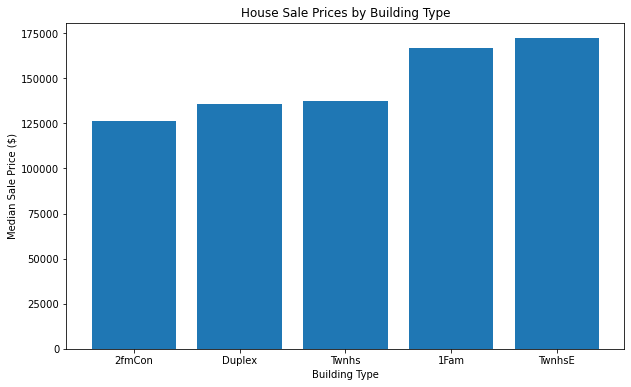

In [86]:
buildings = houses.groupby('BldgType').aggregate({'SalePrice': 'median'}).reset_index().sort_values('SalePrice')
fig = plt.figure(figsize=(10, 6))
plt.bar(buildings['BldgType'], buildings['SalePrice'], align = 'center')
plt.xlabel('Building Type')
plt.ylabel('Median Sale Price ($)')
plt.title('House Sale Prices by Building Type')

Text(0.5, 1.0, 'House Sale Prices by Overall Quality')

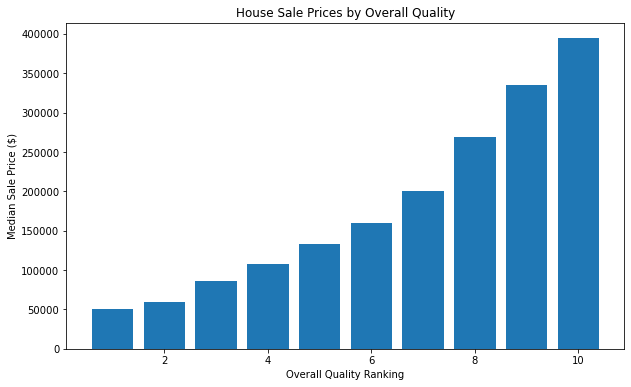

In [87]:
quality = houses.groupby('OverallQual').aggregate({'SalePrice': 'median'}).reset_index().sort_values('SalePrice')
fig = plt.figure(figsize=(10, 6))
plt.bar(quality['OverallQual'], quality['SalePrice'], align = 'center')
plt.xlabel('Overall Quality Ranking')
plt.ylabel('Median Sale Price ($)')
plt.title('House Sale Prices by Overall Quality')

Text(0.5, 1.0, 'House Sale Prices by Overall Condition')

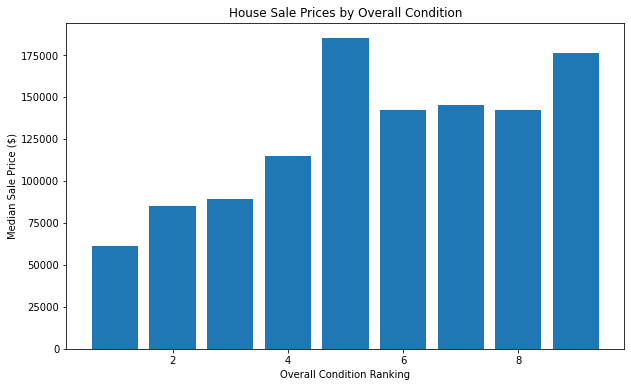

In [88]:
condition = houses.groupby('OverallCond').aggregate({'SalePrice': 'median'}).reset_index().sort_values('SalePrice')
fig = plt.figure(figsize=(10, 6))
plt.bar(condition['OverallCond'], condition['SalePrice'], align = 'center')
plt.xlabel('Overall Condition Ranking')
plt.ylabel('Median Sale Price ($)')
plt.title('House Sale Prices by Overall Condition')

Text(0.5, 1.0, 'Sale Prices for Houses with/without Central Air')

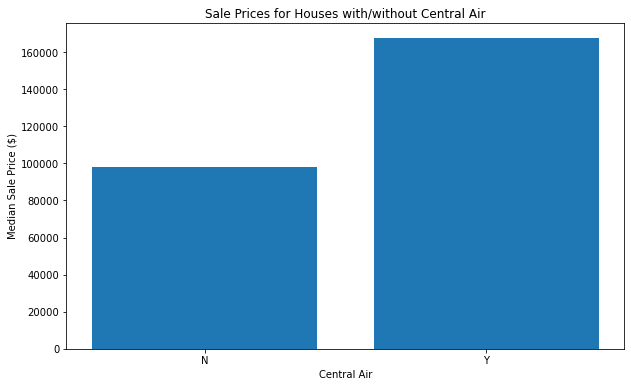

In [89]:
ac = houses.groupby('CentralAir').aggregate({'SalePrice': 'median'}).reset_index().sort_values('SalePrice')
fig = plt.figure(figsize=(10, 6))
plt.bar(ac['CentralAir'], ac['SalePrice'], align = 'center')
plt.xlabel('Central Air')
plt.ylabel('Median Sale Price ($)')
plt.title('Sale Prices for Houses with/without Central Air')

Text(0.5, 1.0, 'Sale Prices for Houses with/without Paved Driveway')

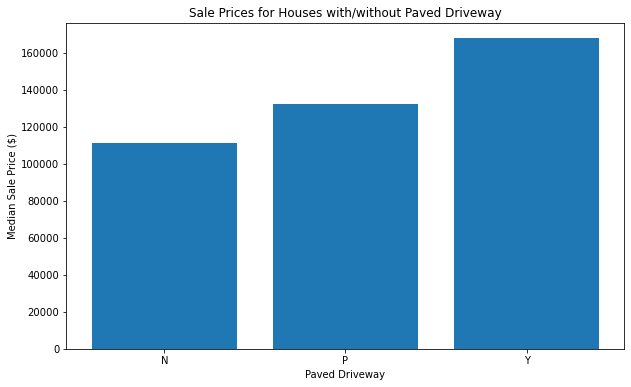

In [90]:
driveway = houses.groupby('PavedDrive').aggregate({'SalePrice': 'median'}).reset_index().sort_values('SalePrice')
fig = plt.figure(figsize=(10, 6))
plt.bar(driveway['PavedDrive'], driveway['SalePrice'], align = 'center')
plt.xlabel('Paved Driveway')
plt.ylabel('Median Sale Price ($)')
plt.title('Sale Prices for Houses with/without Paved Driveway')

Text(0.5, 1.0, 'House Sale Prices by Miscellaneous Feature')

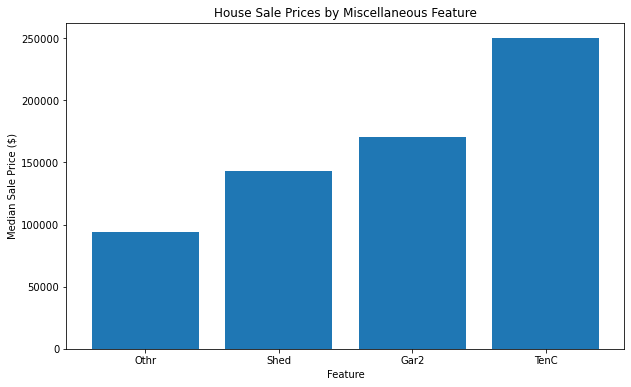

In [91]:
misc = houses.groupby('MiscFeature').aggregate({'SalePrice': 'median'}).reset_index().sort_values('SalePrice')
fig = plt.figure(figsize=(10, 6))
plt.bar(misc['MiscFeature'], misc['SalePrice'], align = 'center')
plt.xlabel('Feature')
plt.ylabel('Median Sale Price ($)')
plt.title('House Sale Prices by Miscellaneous Feature')

Text(0.5, 1.0, 'House Sale Prices by Fence Condition')

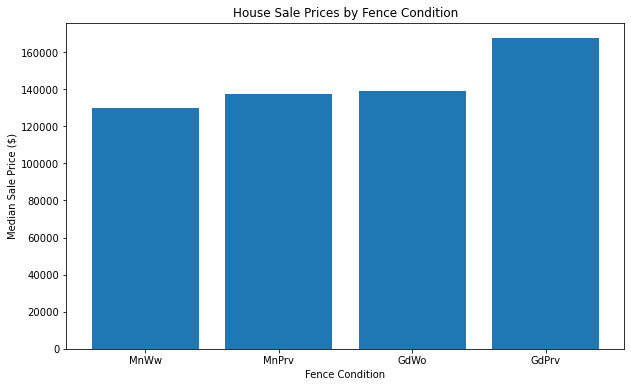

In [92]:
fence = houses.groupby('Fence').aggregate({'SalePrice': 'median'}).reset_index().sort_values('SalePrice')
fig = plt.figure(figsize=(10, 6))
plt.bar(fence['Fence'], fence['SalePrice'], align = 'center')
plt.xlabel('Fence Condition')
plt.ylabel('Median Sale Price ($)')
plt.title('House Sale Prices by Fence Condition')

Text(0.5, 1.0, 'House Sale Prices by Month Sold')

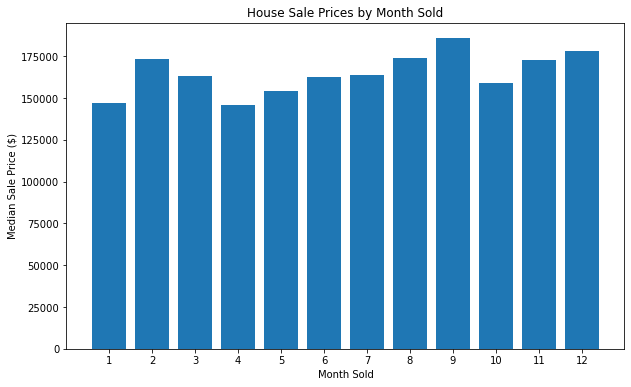

In [93]:
month = houses.groupby('MoSold').aggregate({'SalePrice': 'median'}).reset_index().sort_values('SalePrice')
fig = plt.figure(figsize=(10, 6))
plt.bar(month['MoSold'], month['SalePrice'], align = 'center')
plt.xticks(month['MoSold'], month['MoSold'], rotation = 0, fontsize = 10)
plt.xlabel('Month Sold')
plt.ylabel('Median Sale Price ($)')
plt.title('House Sale Prices by Month Sold')

Text(0.5, 1.0, 'House Sale Prices by Year Sold')

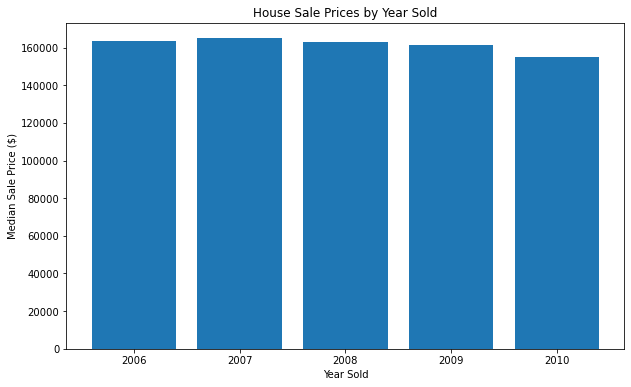

In [94]:
year = houses.groupby('YrSold').aggregate({'SalePrice': 'median'}).reset_index().sort_values('SalePrice')
fig = plt.figure(figsize=(10, 6))
plt.bar(year['YrSold'], year['SalePrice'], align = 'center')
plt.xticks(year['YrSold'], year['YrSold'], rotation = 0, fontsize = 10)
plt.xlabel('Year Sold')
plt.ylabel('Median Sale Price ($)')
plt.title('House Sale Prices by Year Sold')

The month and year the house was sold during doesn't appear be significant in predicting the sale price of the house. The month variable not being significant makes sense but year not being significant is interesting because typically house prices tend to increase over time but this dataset doesn't show any sign of that relationship.

# Linear Model

In [224]:
# Create dummy variables for categorical variables
neigh_dummy = pd.get_dummies(houses['Neighborhood'], prefix = 'Neighborhood_')
air_dummy = pd.get_dummies(houses['CentralAir'], prefix = 'Air_')
drive_dummy = pd.get_dummies(houses['PavedDrive'], prefix = 'Paved_')
misc_dummy = pd.get_dummies(houses['MiscFeature'], prefix = 'Feature_')
fence_dummy = pd.get_dummies(houses['Fence'], prefix = 'Fence_')

In [225]:
# Break up data for python linear regression
data = houses[['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'FirstFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageArea']]
target = pd.DataFrame(houses, columns=["SalePrice_log"])
y = target['SalePrice_log']
data = pd.concat([data, neigh_dummy, air_dummy, drive_dummy, misc_dummy, fence_dummy], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(data, y,
                                   random_state=2023, 
                                   test_size=0.25, 
                                   shuffle=True)

In [226]:
# Fit linear model
lm_model = LinearRegression().fit(X_train, y_train)

In [227]:
# Measure accuracy
predictions = lm_model.predict(X_test)
r = lm_model.score(X_test, y_test)
print(r)

0.8866554009892613


Text(0.5, 1.0, 'Residual Plot Linear Model')

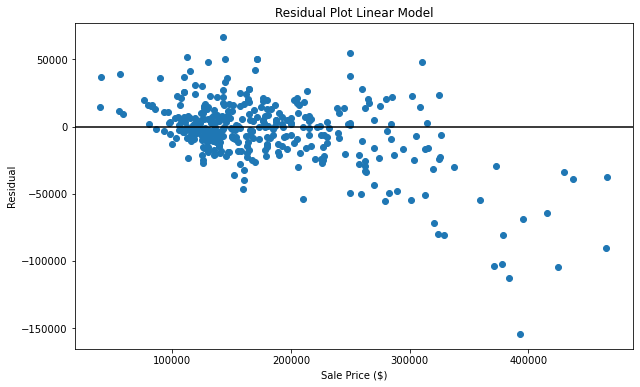

In [228]:
residuals = np.exp(predictions) - np.exp(y_test)
houses['residuals'] = residuals
fig = plt.figure(figsize=(10, 6))
plt.scatter(houses['SalePrice'], houses['residuals'])
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.xlabel('Sale Price ($)')
plt.ylabel('Residual')
plt.title('Residual Plot Linear Model')

The linear model has a serious problem underfitting the houses with high sale prices indicating there may be some underlying factor that is keeping the model from accurately assessing these houses.

In [229]:
# I'm more familiar with working with linear models in a more R format
lm_modelr = smf.ols("SalePrice_log ~ LotArea + OverallQual + OverallCond + YearBuilt + GrLivArea + FullBath + BedroomAbvGr + KitchenAbvGr + Fireplaces + GarageArea + Neighborhood + MiscFeature + CentralAir + PavedDrive", data = houses)
lm_res = lm_modelr.fit()
lm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     22.48
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           4.64e-11
Time:                        22:39:34   Log-Likelihood:                 67.318
No. Observations:                  52   AIC:                            -76.64
Df Residuals:                      23   BIC:                            -20.05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.0868      2.942      0.709      0.485      -4.000       8.173
Neighborhood[T.Blueste]  -5.08e-11   6.67e-11     -0.762      0.454   -1.89e-10    8.72e-11
Neighborhood[T.BrDale]   5.441e-12   7.52e-12      0.723      0.477   -1.01e-11     2.1e-11
Neighborhood[T.BrkSide]     0.0312      0.183      0.171      0.866      -0.347       0.409
Neighborhood[T.ClearCr]     0.1991      0.310      0.643      0.527      -0.442       0.840
Neighborhood[T.CollgCr]     0.2608      0.276      0.945      0.355      -0.310       0.832
Neighborhood[T.Crawfor]     0.4019      0.235      1.714      0.100      -0.083       0.887
Neighborhood[T.Edwards]     0.1162      0.195      0.594      0.558      -0.288       0.520
Neighborhood[T.Gilbert]     0.1020      0.280      0.364      0.719      -0.477       0.681
Neighborhood[T.IDOTRR]     -0.1664      0.226     -0.736      0.469      -0.634       0.301
Neighborhood[T.MeadowV]   1.98e-12   2.74e-12      0.723      0.477   -3.69e-12    7.65e-12
Neighborhood[T.Mitchel]     0.1653      0.242      0.683      0.501      -0.335       0.666
Neighborhood[T.NAmes]       0.1634      0.229      0.713      0.483      -0.311       0.637
Neighborhood[T.NPkVill] -2.136e-14   5.38e-14     -0.397      0.695   -1.33e-13    8.99e-14
Neighborhood[T.NWAmes]      0.1463      0.262      0.558      0.582      -0.396       0.689
Neighborhood[T.NoRidge]   -7.9e-14   4.79e-14     -1.650      0.112   -1.78e-13       2e-14
Neighborhood[T.NridgHt] -1.156e-12   1.64e-12     -0.705      0.488   -4.55e-12    2.23e-12
Neighborhood[T.OldTown]     0.3737      0.173      2.160      0.041       0.016       0.731
Neighborhood[T.SWISU]     1.19e-16   1.75e-16      0.681      0.502   -2.42e-16     4.8e-16
Neighborhood[T.Sawyer]      0.1500      0.233      0.643      0.527      -0.333       0.633
Neighborhood[T.SawyerW]     0.1433      0.282      0.508      0.616      -0.440       0.727
Neighborhood[T.Somerst] -2.912e-16   3.45e-16     -0.844      0.408   -1.01e-15    4.23e-16
Neighborhood[T.StoneBr]  1.255e-16   1.71e-16      0.732      0.471   -2.29e-16     4.8e-16
Neighborhood[T.Timber]  -4.423e-17   4.46e-17     -0.991      0.332   -1.37e-16    4.81e-17
Neighborhood[T.Veenker] -5.673e-18    5.3e-17     -0.107      0.916   -1.15e-16    1.04e-16
MiscFeature[T.Othr]        -0.0326      0.137     -0.237      0.815      -0.317       0.252
MiscFeature[T.Shed]        -0.0994      0.107     -0.926      0.364      -0.321       0.123
MiscFeature[T.TenC]        -0.1976      0.150     -1.316      0.201      -0.508       0.113
CentralAir[T.Y]             0.1247      0.084      1.489      0.150      -0.049       0.298
PavedDrive[T.P]            -0.0330      0.158     -0.209      0.836      -0.360       0.293
PavedDrive[T.Y]             0.1019      0.089  

In [230]:
anova = sm.stats.anova_lm(lm_res)
anova

,df,sum_sq,mean_sq,F,PR(>F)
Neighborhood,24.0,5.250433,0.218768,22.010846,8.698059e-11
MiscFeature,3.0,0.228445,0.076148,7.661502,1.005305e-03
CentralAir,1.0,0.027364,0.027364,2.753122,1.106407e-01
PavedDrive,2.0,0.109690,0.054845,5.518094,1.102934e-02
LotArea,1.0,0.012809,0.012809,1.288735,2.679734e-01
OverallQual,1.0,0.453313,0.453313,45.609027,6.888418e-07
OverallCond,1.0,0.000053,0.000053,0.005309,9.425456e-01
YearBuilt,1.0,0.009976,0.009976,1.003684,3.268450e-01
GrLivArea,1.0,0.147527,0.147527,14.843047,8.105162e-04
FullBath,1.0,0.030712,0.030712,3.089978,9.207912e-02


# Random Forest

In [102]:
rf_workflow = Pipeline(steps = [('rf', RandomForestRegressor(n_estimators=500))])
rf_tune_grid = {'rf__max_features': [5, 10, 15, 20, 30, 50]}

In [103]:
rf_search = GridSearchCV(rf_workflow, rf_tune_grid, cv=5)
rf_search_results = rf_search.fit(X_train, y_train)

In [104]:
rf_search_results.best_score_

0.8602522668592426

In [105]:
rf_search_results.best_params_

{'rf__max_features': 15}

In [106]:
var_imp_df = pd.DataFrame({'feature_name': X_train.columns,
                           'var_imp': rf_search_results.best_estimator_.named_steps['rf'].feature_importances_})

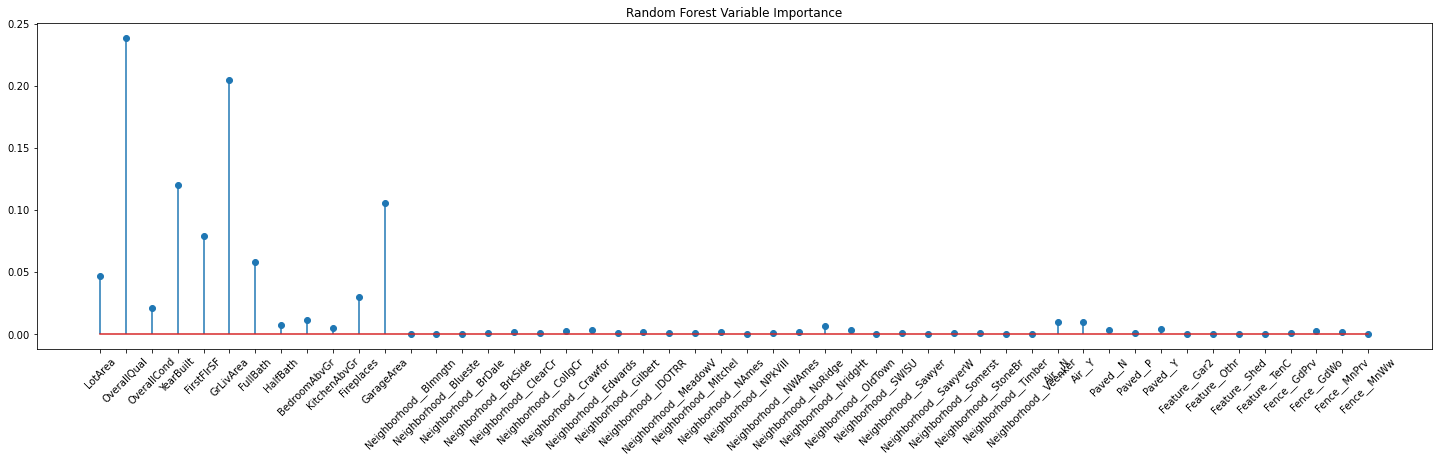

In [107]:
fig, ax = plt.subplots(figsize=(25, 6))

ax.stem(var_imp_df.feature_name, var_imp_df.var_imp)
plt.xticks(var_imp_df.feature_name, var_imp_df.feature_name, rotation = 45, fontsize = 10)
plt.title('Random Forest Variable Importance')
plt.show()

It appears that the conclusions made during EDA hold true according to the model's assessment of variable importance with the predictors: Overall Quality, First Floor Square Footage, and Overall Condition being the three most important.

In [109]:
rf = RandomForestRegressor(n_estimators = 500, max_features = 15, random_state = 2023)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=15, n_estimators=500, random_state=2023)

In [110]:
scores = cross_val_score(RandomForestRegressor(), X_train, y_train, scoring='neg_mean_squared_error', cv = 10)
rmse = sum((-scores)**0.5)/10
print(rmse)

0.1472076786216538


In [219]:
predictions = np.exp(rf.predict(X_test))
r = rf.score(X_test, y_test)
print(r)

0.8802154786429548


Text(0.5, 1.0, 'Residual Plot Random Forest Model')

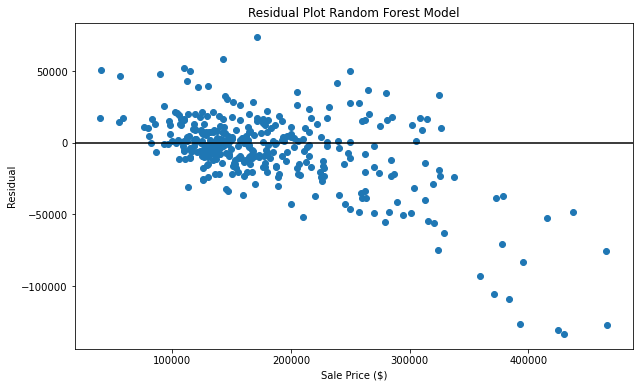

In [112]:
residuals = predictions - np.exp(y_test)
houses['residuals'] = residuals
fig = plt.figure(figsize=(10, 6))
plt.scatter(houses['SalePrice'], houses['residuals'])
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.xlabel('Sale Price ($)')
plt.ylabel('Residual')
plt.title('Residual Plot Random Forest Model')

The random forest is having the same problem as the linear model, assessing houses with high sale prices which may indicate that it isn't the model that is at fault but that an important variable may be missing that can help this problem.

# XGBoost

In [113]:
gbm_workflow = Pipeline(steps = [('gbm', xgb.XGBRegressor(objective="reg:squarederror"))])

gbm_tune_grid = {'gbm__learning_rate': [0.01, 0.05, 0.1, 0.25],
                'gbm__n_estimators': [100, 200, 300, 400, 500, 1000],
                'gbm__max_depth': [1, 3, 5]}

In [114]:
gbm_search = GridSearchCV(gbm_workflow, gbm_tune_grid, cv=5)
gbm_search_results = gbm_search.fit(X_train, y_train)

In [115]:
gbm_search_results.best_score_

0.8714174283037686

In [116]:
gbm_search_results.best_params_

{'gbm__learning_rate': 0.05, 'gbm__max_depth': 3, 'gbm__n_estimators': 500}

In [185]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", learning_rate = 0.05, max_depth = 3, n_estimators = 500).fit(X_train, y_train)

In [119]:
scores = cross_val_score(XGBRegressor(objective='reg:squarederror'), X_train, y_train, scoring='neg_mean_squared_error', cv = 10)

In [120]:
rmse = sum((-scores)**0.5)/10
print(rmse)

0.1497542524315553


In [222]:
var_imp_df = pd.DataFrame({'feature_name': X_train.columns,
                           'var_imp': xgb_model.feature_importances_})

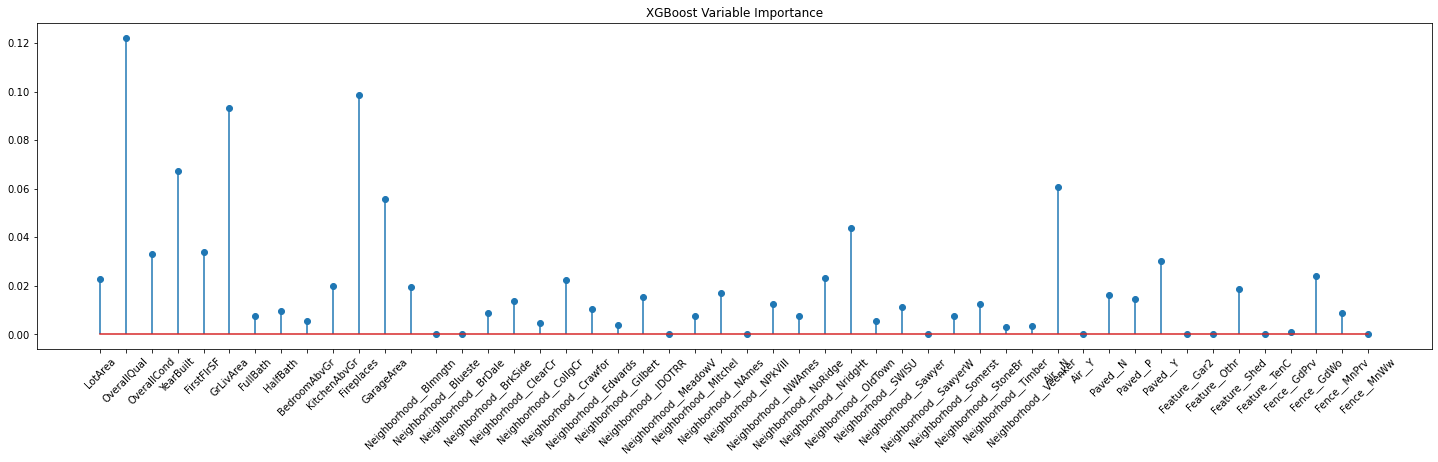

In [223]:
fig, ax = plt.subplots(figsize=(25, 6))

ax.stem(var_imp_df.feature_name, var_imp_df.var_imp)
plt.xticks(var_imp_df.feature_name, var_imp_df.feature_name, rotation = 45, fontsize = 10)
plt.title('XGBoost Variable Importance')
plt.show()

The XG Boost model identified similar variable that the random forest identified as important along with other significant ones such as Central Air, Kitchens, and a few neighborhoods. 

In [193]:
predictions = np.exp(xgb_model.predict(X_test))

Text(0.5, 1.0, 'Residual Plot XGBoost Model')

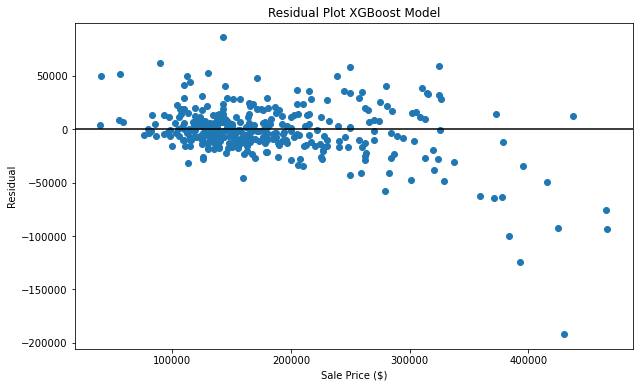

In [194]:
residuals = predictions - np.exp(y_test)
houses['residuals'] = residuals
fig = plt.figure(figsize=(10, 6))
plt.scatter(houses['SalePrice'], houses['residuals'])
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.xlabel('Sale Price ($)')
plt.ylabel('Residual')
plt.title('Residual Plot XGBoost Model')

The same problem remains... The model is still having difficulty predicting large housing sale prices.

In [196]:
r = xgb_model.score(X_test, y_test)
print(r)

0.8932542246543405


In [232]:
# Add predictions and residuals to dataframe for analysis
pred_df = data
pred_df['predicted'] = np.exp(xgb_model.predict(pred_df))
pred_df['SalePrice'] = houses['SalePrice']
pred_df['residual'] = abs(pred_df['SalePrice'] - pred_df['predicted'])
pred_df

,LotArea,OverallQual,OverallCond,YearBuilt,FirstFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,...,Feature__Othr,Feature__Shed,Feature__TenC,Fence__GdPrv,Fence__GdWo,Fence__MnPrv,Fence__MnWw,predicted,SalePrice,residual
0,8450,7,5,2003,856,1710,2,1,3,1,...,0,0,0,0,0,0,0,198953.562500,208500,9546.437500
1,9600,6,8,1976,1262,1262,2,0,3,1,...,0,0,0,0,0,0,0,178855.187500,181500,2644.812500
2,11250,7,5,2001,920,1786,2,1,3,1,...,0,0,0,0,0,0,0,208088.750000,223500,15411.250000
3,9550,7,5,1915,961,1717,1,0,3,1,...,0,0,0,0,0,0,0,153962.406250,140000,13962.406250
4,14260,8,5,2000,1145,2198,2,1,4,1,...,0,0,0,0,0,0,0,308022.187500,250000,58022.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,6,5,1999,953,1647,2,1,3,1,...,0,0,0,0,0,0,0,178758.156250,175000,3758.156250
1456,13175,6,6,1978,2073,2073,2,0,3,1,...,0,0,0,0,0,1,0,233768.656250,210000,23768.656250
1457,9042,7,9,1941,1188,2340,2,0,4,1,...,0,1,0,1,0,0,0,258375.109375,266500,8124.890625
1458,9717,5,6,1950,1078,1078,1,0,2,1,...,0,0,0,0,0,0,0,124482.835938,142125,17642.164062


In [216]:
# Take a look at the sales with the largest residuals
pred_df.sort_values('residual', ascending = False).head(25)

,LotArea,OverallQual,OverallCond,YearBuilt,FirstFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,...,Feature__Othr,Feature__Shed,Feature__TenC,Fence__GdPrv,Fence__GdWo,Fence__MnPrv,Fence__MnWw,predicted,SalePrice,residual
496,12692,8,5,1992,3228,3228,3,0,4,1,...,0,0,0,0,0,0,0,238336.156250,430000,191663.843750
1181,5587,8,5,2008,1652,1652,2,0,2,1,...,0,0,0,0,0,0,0,268188.156250,392500,124311.843750
112,9965,7,5,2007,1282,2696,2,1,4,1,...,0,0,0,0,0,0,0,283725.968750,383970,100244.031250
1373,11400,10,5,2001,2633,2633,2,1,2,1,...,0,0,0,0,0,0,0,372751.625000,466500,93748.375000
1142,9965,8,5,2006,1466,2828,3,0,4,1,...,0,0,0,0,0,0,0,332387.906250,424870,92482.093750
1324,9986,8,5,2006,1795,1795,2,0,2,1,...,0,0,0,0,0,0,0,238751.093750,147000,91751.093750
588,25095,5,8,1968,1473,1473,1,0,1,1,...,0,0,0,0,0,0,0,229032.546875,143000,86032.546875
1243,13891,10,5,2006,2076,2076,2,1,2,1,...,0,0,0,0,0,0,0,389606.812500,465000,75393.187500
473,14977,8,5,2006,1976,1976,2,0,2,1,...,0,0,0,0,0,0,0,366725.281250,440000,73274.718750
688,8089,8,6,2007,1419,1419,2,0,2,1,...,0,0,0,0,0,0,0,324711.031250,392000,67288.968750


In [217]:
data.describe()

,LotArea,OverallQual,OverallCond,YearBuilt,FirstFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,...,Feature__Othr,Feature__Shed,Feature__TenC,Fence__GdPrv,Fence__GdWo,Fence__MnPrv,Fence__MnWw,predicted,SalePrice,residual
count,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,...,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000
mean,10019.608155,6.078784,5.577747,1971.089150,1155.086386,1504.076710,1.557015,0.381479,2.863856,1.046994,...,0.001382,0.032481,0.000691,0.040774,0.037319,0.107809,0.007602,176807.437500,177948.160332,11463.898737
std,5489.517792,1.363681,1.116023,30.228653,378.731814,507.288537,0.544713,0.502706,0.813178,0.221282,...,0.037165,0.177335,0.026288,0.197835,0.189607,0.310247,0.086887,67910.679688,71670.471040,12976.882586
min,1300.000000,1.000000,1.000000,1872.000000,334.000000,334.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37519.089844,34900.000000,2.148438
25%,7500.000000,5.000000,5.000000,1954.000000,881.000000,1127.000000,1.000000,0.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129273.148438,129900.000000,3625.636719
50%,9439.000000,6.000000,5.000000,1972.000000,1082.000000,1456.000000,2.000000,0.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,160638.203125,162000.000000,8057.687500
75%,11489.000000,7.000000,6.000000,2000.000000,1379.500000,1768.000000,2.000000,1.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,208086.757812,212450.000000,14838.648438
max,70761.000000,10.000000,9.000000,2010.000000,4692.000000,5642.000000,3.000000,2.000000,8.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,464992.281250,485000.000000,191663.843750


The mean absolute error is much lower than the standard deviation of housing sale prices which isn't bad for an initial model, however the standard deviation of the residuals is higher than the mean which could be lower if not for a few large mispreidictions in the dataset. This is a problem that needs to be further explored and may indicate that another variable may be confounding the relationship between the current set of predictors and the response.

(Cool Note) The minimum residual was approximately two dollars, which means one prediction was almost perfect in predicting the actual housing sale price.